# 例：クーポンの配布

ECサイトにおいてクーポンをユーザーに配布する施策を行った状況を想定し、クーポンという処置が購入する確率に与えた影響を調べたいとする。その際に、

1. ランダムにクーポン配布が行われたケース
2. 前月に購入したユーザーのうちランダムに選んだ半分にクーポンが配布されたケース

という2つの処置割当メカニズムがあったと仮定して比較を行う。クーポンは同じもので効果も同じとする。

また、ユーザーは通常の顧客と、成約率が高いロイヤルカスタマーの2種類いるとする。

乱数を生成してシミュレーションしてみる

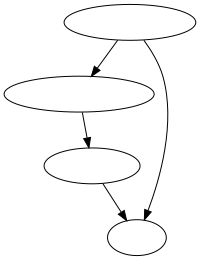

In [1]:
import graphviz
g = graphviz.Digraph()
g.edge('ロイヤルティ', '先月の購入履歴')
g.edge('先月の購入履歴', 'クーポン')
g.edge('クーポン', '購入')
g.edge('ロイヤルティ', '購入')
g

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(0)

ate = 0.1  # 真の効果
n = 1000
users = pd.DataFrame()

# 通常の顧客とロイヤルカスタマーの2つのグループがあり、毎月の成約率が異なるとする
p_normal = 0.2
p_loyal = 0.5

# ロイヤルカスタマーは全体の2割いるとする
is_loyal = np.random.binomial(n=1, p=0.2, size=n)


def generate_data():
    # 先月の購入の有無
    is_buy_normal = is_loyal * np.random.binomial(n=1, p=p_loyal, size=n)
    is_buy_loyal = (1 - is_loyal) * np.random.binomial(n=1, p=p_normal, size=n)
    users.loc[:, "prev_purchase"] = is_buy_normal + is_buy_loyal

    # 1. ランダム配布の場合
    d = np.random.binomial(n=1, p=0.5, size=n)
    is_buy_normal = d * np.random.binomial(n=1, p=p_normal + ate, size=n) + (1 - d) * np.random.binomial(n=1, p=p_normal, size=n)
    is_buy_loyal = d * np.random.binomial(n=1, p=p_loyal + ate, size=n) + (1 - d) * np.random.binomial(n=1, p=p_loyal, size=n)
    users.loc[:, "purchase_1"] = is_loyal * is_buy_loyal + (1 - is_loyal) * is_buy_normal
    users.loc[:, "assignment_1"] = d

    # 2. ユーザーを選ぶ場合
    d = users["prev_purchase"] * np.random.binomial(n=1, p=0.5, size=n)
    is_buy_normal = d * np.random.binomial(n=1, p=p_normal + ate, size=n) + (1 - d) * np.random.binomial(n=1, p=p_normal, size=n)
    is_buy_loyal = d * np.random.binomial(n=1, p=p_loyal + ate, size=n) + (1 - d) * np.random.binomial(n=1, p=p_loyal, size=n)
    users.loc[:, "purchase_2"] = is_loyal * is_buy_loyal + (1 - is_loyal) * is_buy_normal
    users.loc[:, "assignment_2"] = d

    return users

In [7]:
df = generate_data()

# 各群の平均の差分をとって（ナイーブな推定量を使って）ATEを推定してみる
agg1 = df.groupby("assignment_1")["purchase_1"].agg(["mean", "count"])
agg2 = df.groupby("assignment_2")["purchase_2"].agg(["mean", "count"])
result = f"""
--- ナイーブな推定量 ---
1. ランダム配布の場合
対照群： 成約率={agg1['mean'][0]:.3g} n={agg1['count'][0]:,}
処置群： 成約率={agg1['mean'][1]:.3g} n={agg1['count'][1]:,}
成約率の差： {agg1['mean'][1] - agg1['mean'][0]:.3g}

2. ユーザーを選ぶ場合
対照群： 成約率={agg2['mean'][0]:.3g} n={agg2['count'][0]:,}
処置群： 成約率={agg2['mean'][1]:.3g} n={agg2['count'][1]:,}
成約率の差： {agg2['mean'][1] - agg2['mean'][0]:.3g}
"""
print(result)


--- ナイーブな推定量 ---
1. ランダム配布の場合
対照群： 成約率=0.248 n=533
処置群： 成約率=0.347 n=467
成約率の差： 0.0992

2. ユーザーを選ぶ場合
対照群： 成約率=0.238 n=849
処置群： 成約率=0.424 n=151
成約率の差： 0.186



In [8]:
df.corr()

,prev_purchase,purchase_1,assignment_1,purchase_2,assignment_2
prev_purchase,1.000000,0.112856,0.012899,0.136315,0.667983
purchase_1,0.112856,1.000000,0.108676,0.083434,0.089539
assignment_1,0.012899,0.108676,1.000000,-0.010079,0.002704
purchase_2,0.136315,0.083434,-0.010079,1.000000,0.150649
assignment_2,0.667983,0.089539,0.002704,0.150649,1.000000


In [9]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer

models = [
    smf.ols('purchase_1 ~ assignment_1', data=df).fit(),
    smf.ols('purchase_2 ~ assignment_2', data=df).fit(),
    smf.ols('purchase_2 ~ assignment_2 + prev_purchase', data=df).fit(),
]
Stargazer(models)

ランダムじゃない割り付けだった`purchase_2`のほうでも、 `prev_purchase` を入れるとバイアスが減少している

#### モンテカルロシミュレーション

`purchase_2 ~ assignment_2 + prev_purchase`の推定値がたまたまではないことを確認する


In [16]:
tau_hats = []
for i in range(1000):
    np.random.seed(i)
    df = generate_data()
    res = smf.ols('purchase_2 ~ assignment_2 + prev_purchase', data=df).fit()
    tau_hat = res.params["assignment_2"]
    tau_hats.append(tau_hat)

tau_hats = pd.Series(tau_hats)

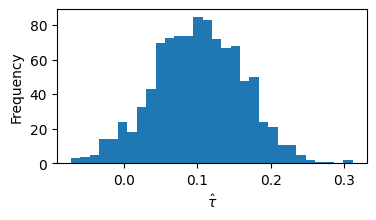

In [20]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=[4,2])
ax.hist(tau_hats, bins=30)
ax.set(xlabel=r"$\hat{\tau}$", ylabel="Frequency")
fig.show()